<span style="font-family:Papyrus; font-size:3em;">Lecture 12: Cross Validation</span>

This notebook describes how to do cross validation with simulation models.

# Programming Preliminaries

In [1]:
IS_COLAB = False
#
if IS_COLAB:
  !pip install matplotlib
  !pip install numpy
  !pip install tellurium
  !pip install SBstoat
#    
# Constants for standalone notebook
if not IS_COLAB:
    CODE_DIR = "/home/ubuntu/advancing-biomedical-models/common"
    DATA_DIR = "/home/ubuntu/advancing-biomedical-models/lecture_11"
else:
    from google.colab import drive
    drive.mount('/content/drive')
    CODE_DIR = "/content/drive/MyDrive/Winter 2021/common"
    DATA_DIR = "/content/drive/MyDrive/Winter 2021/Lecture Notes/11_lecture"
import sys
sys.path.insert(0, CODE_DIR)

In [19]:
%matplotlib inline
import tellurium as te
import numpy as np
import lmfit   # Fitting lib
import math
import random 
import matplotlib.pyplot as plt
from SBstoat.modelFitter import ModelFitter
from SBstoat.namedTimeseries import NamedTimeseries

# Model

In [3]:
# The simulation model
MODEL = """
     A -> B; k1*A
     B -> C; k2*B
      
     A = 5;
     B = 0;
     C = 0;
     k1 = 0.1
     k2 = 0.2
"""

In [4]:
# Experimental conditions
SIM_TIME = 30
NUM_POINT = 15
NOISE_STD = 1.0
NUM_FOLD = 3

# Helper Functions

In [5]:
def runSimulation(simTime=SIM_TIME, numPoint=NUM_POINT, roadRunner=None, parameters=None, model=MODEL):
    """
    Runs the simulation model rr for the parameters.
   
    Parameters
    ----------
    endTime: float
        End time for the simulation
    numPoints: int
        Number of points in the simulation
    """
    if roadRunner is None:
        roadRunner = te.loada(MODEL)
    else:
        raodRunner.reset()
    if parameters is not None:
        parameterDct = parameters.valuesdict()
        # Set the simulation constants for all parameters
        for name in parameterDct.keys():
            roadRunner[name] = parameterDct[name]
    return roadRunner.simulate (0, simTime, numPoint)

# TESTS
FITTED_DATA = runSimulation()
assert(np.size(FITTED_DATA) == NUM_POINT*4)
assert(FITTED_DATA[0, 1] == 5)

In [7]:
def generateObservedData(fittedData=FITTED_DATA, noiseStd = NOISE_STD):
    # Create the experimental data. We refer to these as the observations
    numRow, numCol = np.shape(fittedData)
    # Create some 'experimental' data 
    obsData = fittedData.copy()
    # Add noise
    for i in range (numRow):
        for j in range(numCol):
            obsData[i, j] = max(obsData[i, j] + np.random.normal(0, noiseStd, 1), 0)
    return obsData
        
# Tests
OBSERVED_DATA = generateObservedData()
assert(np.shape(OBSERVED_DATA) == np.shape(FITTED_DATA))
msr = np.sqrt(sum((OBSERVED_DATA.flatten() - FITTED_DATA.flatten())**2)/FITTED_DATA.size)
assert(np.abs(msr - NOISE_STD) < 1.0)

In [8]:
np.shape(OBSERVED_DATA)

(15, 4)

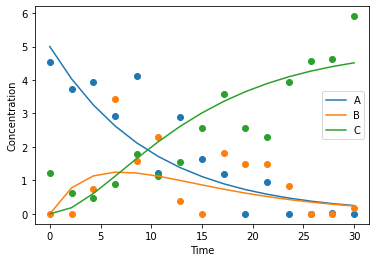

In [9]:
def plotFittedAndObserved(fittedData=FITTED_DATA, observedData=OBSERVED_DATA, indices=None,
                         title=""):
    # Plot the simulation data.
    numRow, numCol = np.shape(fittedData)
    if indices is None:
        indices = [v for v in range(numRow)]            
    fig, ax = plt.subplots(1)
    for col in range(1, numCol):
        ax.plot(fittedData[indices, 0], fittedData[indices, col])
        ax.scatter(fittedData[indices, 0], observedData[indices, col])
    ax.set_xlabel("Time")
    ax.set_ylabel("Concentration")
    ax.set_title(title)
    ax.legend(['A', 'B', 'C'])
    plt.show() 
    
# Tests
plotFittedAndObserved()

# Constructing Folds

In [10]:
# Generates indices of training and test data
# by alternating between folds
def foldGenerator(numPoint, numFold):
    """
    Generates pairs of trainining and test indices.
    
    Parameters:
    ----------
    numPoint: int
        number of time points
    numFold: int
        number of pairs of testIndices and trainIndices
    
    Returns:
    --------
    list of pairs of train indices, test indices
    """
    indices = range(numPoint)
    for remainder in range(numFold):
        testIndices = []
        for idx in indices:
            if idx % numFold == remainder:
                testIndices.append(idx)
        trainIndices = np.array(
            list(set(indices).difference(testIndices)))
        testIndices = np.array(testIndices)
        yield trainIndices, testIndices

In [11]:
generator = foldGenerator(NUM_POINT, NUM_FOLD)  # Create the iterator object
for trainIndices, testIndices in generator:
    print((trainIndices, testIndices))

(array([ 1,  2,  4,  5,  7,  8, 10, 11, 13, 14]), array([ 0,  3,  6,  9, 12]))
(array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14]), array([ 1,  4,  7, 10, 13]))
(array([ 0,  1,  3,  4,  6,  7,  9, 10, 12, 13]), array([ 2,  5,  8, 11, 14]))


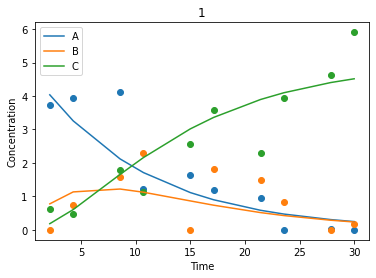

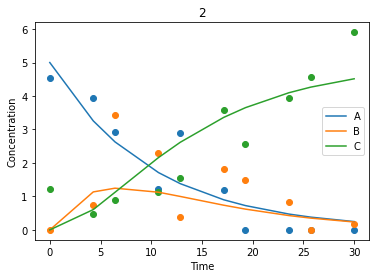

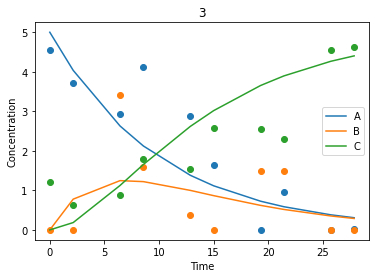

In [12]:
# Run the simulation
generator = foldGenerator(NUM_POINT, NUM_FOLD)  # Create the iterator object
fold = 1
for trainIndices, testIndices in generator:
    plotFittedAndObserved(indices=trainIndices, title=str(fold))
    fold += 1
        